In [2]:
import copy

import prody
from rdkit import Chem
from rdkit.Chem import Draw
from prody.proteins.functions import showProtein, view3D

from rgroup import rep2D, draw3D, merge_R_group, fix_receptor, optimise_in_receptor, sort_conformers

In [3]:
# load the complex with the ligand
sys = prody.parsePDB('5NEV.pdb1')
rec = sys.select('not (nucleic or hetatm) and not water')
mol = sys.select('resname 72L')

prody.writePDB('rec.pdb', rec)
# prody.writePDB('lig.pdb', mol)

@> 4485 atoms and 1 coordinate set(s) were parsed in 0.04s.


'rec.pdb'

In [4]:
!wget 'https://models.rcsb.org/v1/5nev/ligand?auth_seq_id=301&label_asym_id=E&encoding=sdf&filename=5nev_E_72L.sdf' -O lig.sdf
!obabel lig.sdf -O ligh.sdf -h -p 7
# ^manually modify the files if need be

zsh:1: command not found: wget
zsh:1: command not found: obabel


In [5]:
# load the ligand
# rdkit doesn't do a good job with protonation, 
#init_mol = Chem.MolFromPDBFile('lig.pdb', removeHs=False)
#init_mol = Chem.AddHs(init_mol, addCoords=True)

init_mol = Chem.SDMolSupplier('ligh.sdf', removeHs=False)[0]

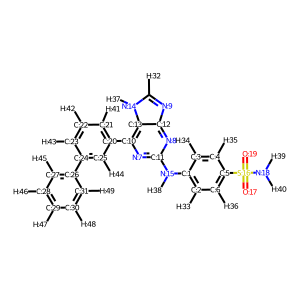

In [6]:
# select the atom to be replaced with the R group
Draw.MolToImage(rep2D(init_mol))

In [7]:
# load the R group
R_group = Chem.MolFromMolFile('data/rgroups/molecules/alcohols/propane-1_2_3-triol-r.mol', removeHs=False)
draw3D(R_group)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [8]:
rmol = merge_R_group(init_mol, R_group, 47)
rmol.draw3D()

Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x12e3c2280> neighbouring <rdkit.Chem.rdchem.Atom object at 0x12e3c2220>


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

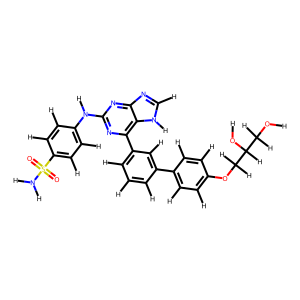

In [9]:
Draw.MolToImage(rep2D(rmol, idx=False))

In [10]:
toxicity = rmol.toxicity()
toxicity

,MW,HBA,HBD,LogP,Pass_Ro5,has_pains,has_unwanted_subs
0,532.152889,9,5,2.8099,True,False,False


In [11]:
# visualise the template
# draw3D(rmol.template)

In [12]:
rmol.draw3D()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [13]:
rmol.generate_conformers(num_conf=30, minimum_conf_rms=0.5)

removed 9 duplicated conformations


In [14]:
rmol.draw3Dconfs()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [15]:
rmol.GetNumConformers()

22

In [16]:
# fix the receptor file 
fix_receptor("rec.pdb", "rec_h.pdb")
# load back into prody
rec_fix = prody.parsePDB("rec_h.pdb")

@> 8925 atoms and 1 coordinate set(s) were parsed in 0.06s.


In [17]:
# filter by the protein clashes
view = view3D(rec_fix)
rmol.draw3Dconfs(view)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [23]:
import py3Dmol
view = py3Dmol.view(width=300, height=300, viewergrid=(1, 1))

for conf in rmol.GetConformers():
    mb = Chem.MolToMolBlock(rmol, confId=conf.GetId())
    view.addModel(mb, "lig")

view.setStyle({'stick':{}})
view.zoomTo()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [25]:
rmol.removeConfsClashingWithProdyProt(rec_fix)

In [26]:
view = view3D(rec_fix)
#rmol.draw3Dconfs(view)

In [34]:
opt_mol, energies = optimise_in_receptor(
     ligand=rmol, 
     receptor_file="rec_h.pdb", 
     ligand_force_field="openff", 
     use_ani=True,
     sigma_scale_factor=0.8,
     relative_permittivity=4
 )

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. RDMol name: 72LUndefined chiral centers are:
 - Atom C (index 54)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 5)



using ani2x


Optimising conformer: 100%|█████████████████████| 17/17 [00:27<00:00,  1.64s/it]


In [35]:
type(opt_mol)
opt_mol.draw3Dconfs()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [36]:
opt_mol.to_file("optimised_corrds.pdb")

In [37]:
print(energies)

[-1240624.8122279858, -1240629.1091668878, -1240627.1925699806, -1240629.239045589, -1240627.9142029264, -1240624.8466869872, -1240632.9462469465, -1240627.799854414, -1240630.1286370705, -1240625.2049657092, -1240629.5860918243, -1240639.2053759843, -1240629.1804791156, -1240625.856151261, -1240627.816689506, -1240641.4117411233, -1240635.792487726]


In [38]:
final_mol = sort_conformers(ligand=opt_mol, energies=energies, energy_range=5)

In [39]:
final_mol.to_file("best_conformers.pdb")